# ML4SCI Task

This notebook demonstrates the implementation of model trained on data provided for **Specific Task V: Exploring Transformers**

## WorkFlow
- Create `data_helper` class which return a DataFrame for The dataset which contain `target` and `data_path` column
- Split the Data into train and validation set using `train_test_split` in **90:10** ratio
- Configuration class used to set the hyperparameters
- Define `get_transforms` function for data augmentation
- Define `CustomDataset` class
- Define `PretrainedModel` class which uses **timm** to load pretrained VIT Model
- Define `train_utils` class which contain functions to get loss, optimizer, scheduler, score
- Define `Train` class which contain function for train and validation for one epoch and the train loop

In [1]:
# importing necessary library
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import timm
import cv2

# importing torch_libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading 2 images from each class to plot
data_sub_1 = cv2.imread('/kaggle/input/deeplense-transform/lenses/sub/image_100320807541648655929202108326967225168.jpg')
data_no_sub_1 = cv2.imread('/kaggle/input/deeplense-transform/lenses/no_sub/image_101413590224723510154660000143587270224.jpg')

Text(0.5, 1.0, 'No_Sub')

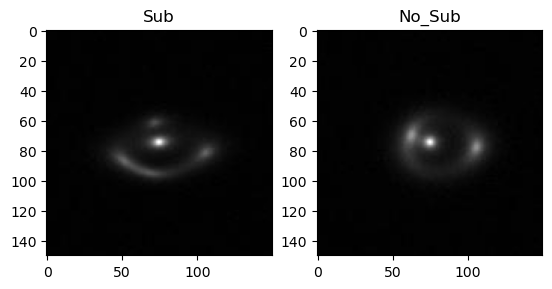

In [3]:
#plotting the image for both class
plt.subplot(1,2,1)
plt.imshow(data_sub_1)
plt.title("Sub")
plt.subplot(1,2,2)
plt.imshow(data_no_sub_1)
plt.title("No_Sub")

In [4]:
# Defining directory for both file and one common directory
root_dir = '/kaggle/input/deeplense-transform/lenses'
dir_no_sub = root_dir+'/no_sub/'
dir_sub = root_dir+'/sub/'

In [5]:
# List for all images in the corrosponding file
path_no_sub = os.listdir('/kaggle/input/deeplense-transform/lenses/no_sub')
path_sub = os.listdir('/kaggle/input/deeplense-transform/lenses/sub')

In [6]:
print("Length of no sub data =", len(path_no_sub))
print("Length of sub data =", len(path_sub))

Length of no sub data = 5000
Length of sub data = 5000


In [7]:
# Helper function to create dataframe having target and data_path
def data_helper():
    df = pd.DataFrame()
    target = []
    data_path = []
    
    for i in path_no_sub:
        target.append(0)
        data_path.append(dir_no_sub+i)
    for i in path_sub:
        target.append(1)
        data_path.append(dir_sub+i)
        
    df['target'] = target
    df['data_path'] = data_path
    df = df.sample(frac=1, random_state=42)
    
    return df

In [8]:
data_df = data_helper()
data_df.head()

,target,data_path
6252,1,/kaggle/input/deeplense-transform/lenses/sub/i...
4684,0,/kaggle/input/deeplense-transform/lenses/no_su...
1731,0,/kaggle/input/deeplense-transform/lenses/no_su...
4742,0,/kaggle/input/deeplense-transform/lenses/no_su...
4521,0,/kaggle/input/deeplense-transform/lenses/no_su...


In [9]:
# Splitting the data into train and validation set with validation size = 10% and stratified according 
# to target to make sure class is balanced across both the dataset
train_df, val_df = train_test_split(data_df, stratify=data_df['target'], test_size=0.1, random_state=2023)
train_df.head()

,target,data_path
8318,1,/kaggle/input/deeplense-transform/lenses/sub/i...
8075,1,/kaggle/input/deeplense-transform/lenses/sub/i...
4969,0,/kaggle/input/deeplense-transform/lenses/no_su...
4453,0,/kaggle/input/deeplense-transform/lenses/no_su...
7527,1,/kaggle/input/deeplense-transform/lenses/sub/i...


In [10]:
val_df.head()

,target,data_path
4633,0,/kaggle/input/deeplense-transform/lenses/no_su...
4342,0,/kaggle/input/deeplense-transform/lenses/no_su...
3906,0,/kaggle/input/deeplense-transform/lenses/no_su...
839,0,/kaggle/input/deeplense-transform/lenses/no_su...
3330,0,/kaggle/input/deeplense-transform/lenses/no_su...


In [11]:
# Configuration class
class CFG:
    lr = 0.0001
    batch_size = 32
    num_classes = 1
    size=[224, 224]
    target_col="target"
    epochs = 10
    seed = 42
    num_workers = 2
    transform = False
    weight_decay = 3e-5
    num_workers=2
    train=True
    debug=False
    metric_type="roc_auc"
    scheduler_type = "CosineLRScheduler"
    optimizer_type = "Adam"
    loss_type = "BCEWithLogitsLoss"
    max_grad_norm = 1000
    lr_max = 3e-4
    epochs_warmup = 1.0
    model_name = "vit_base_patch16_224"

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# If Debug is set to true and then it reduce the size of data to check the implementation immediatly
if CFG.debug==True:
    train_df = train_df[:100]
    val_df = val_df[:100]

In [14]:
# Augmentation
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Rotate(limit=20),
            A.InvertImg(), 
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])


In [15]:
# Pytorch dataset creation
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['data_path']
        image = cv2.imread(image_path.iloc[idx]).astype(np.float32)
        labels = self.df['target'].iloc[idx].astype(np.float32)
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return torch.tensor(image), torch.tensor(labels)

In [16]:
# Helper Function
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
# Checking dataset
dataa = CustomDataset(train_df, transform=get_transforms(data='train'))
img, labels = dataa[4]
print(img.shape)
print(labels)

torch.Size([3, 224, 224])
tensor(1.)


In [18]:
# Pretrained model class
class PretrainedModel(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = timm.create_model(self.model_name, pretrained=self.pretrained, in_chans=3)
        clsf = self.model.default_cfg['classifier']
        n_features = self.model._modules[clsf].in_features
        self.model._modules[clsf] = nn.Identity()
        self.fc = nn.Linear(n_features, CFG.num_classes)
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [19]:
# Class containing loss, optimizer, scheduler and score method
class train_utils():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG
    
    # Defining the Loss Function
    def get_criterion(self):
        if self.CFG.loss_type == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif self.CFG.loss_type == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        return criterion
    
    # Defining the Score Function
    def get_score(self, y_true, y_pred):
        if self.CFG.metric_type == "accuracy_score":
            score =  accuracy_score(y_true, y_pred)
        elif self.CFG.metric_type == "roc_auc":
            score =  roc_auc_score(y_true, y_pred, multi_class="ovr")
        return score
    
    # Defining the Optimizer Function
    def get_optimizer(self, model):
        if self.CFG.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay, amsgrad=False)
        if self.CFG.optimizer_type == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
        return optimizer
    
    # Defining the Scheduler Function
    def get_scheduler(self, optimizer, warmup, nsteps):
        if self.CFG.scheduler_type == "StepLR":
            scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
        if self.CFG.scheduler_type == 'CosineLRScheduler':
            scheduler = CosineLRScheduler(optimizer,
                                          warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,
                                          t_initial=(nsteps - warmup), lr_min=1e-6)
        return scheduler

In [20]:
class Train():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG  
    
    # Function to train one epoch
    def train_fn(self, train_loader, model, criterion, optimizer, epoch, scheduler, device):
        model.train() # switch to training mode
        nbatch = len(train_loader)
        running_loss = AverageMeter()
        for ibatch, (images, labels) in enumerate(tqdm(train_loader, desc="Train")):
            # Load image and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            y_preds = model(images)
            bs = images.size(0)
            
            # calculate the loss
            loss = criterion(y_preds.view(-1), labels)
            running_loss.update(loss.item(), bs)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            optimizer.step()
            
            if self.CFG.scheduler_type == "CosineLRScheduler":
                scheduler.step(epoch * nbatch + ibatch + 1)

        return running_loss.avg

    # Function to validate one epoch
    def valid_fn(self, valid_loader, model, criterion, device):
        model.eval() # switch to evaluation mode
        preds = []
        running_loss = AverageMeter()

        for (images, labels) in tqdm(valid_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)
            bs = images.size(0)

            # compute loss
            with torch.no_grad():
                y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
            running_loss.update(loss.item(), bs)
            # record accuracy
            preds.append(y_preds.sigmoid().to('cpu').numpy())
        predictions = np.concatenate(preds)
        return (running_loss.avg), predictions
    
    # Train loop
    def train_loop(self, train_data, valid_data):

        # create dataset
        train_dataset = CustomDataset(train_data, transform=get_transforms(data='train'))
        valid_dataset = CustomDataset(valid_data, transform=get_transforms(data="valid"))

        # create dataloader
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.CFG.batch_size, shuffle=True, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.CFG.batch_size, shuffle=False, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)

        # create model and transfer to device
    #     model = ConvNeuralNet(CFG.num_classes)
        model = PretrainedModel(pretrained=True)
        model.to(device)
        
        # Creating object of train_utils
        train_obj = train_utils(self.CFG)
        # select optimizer, scheduler and criterion
        nbatch = len(train_loader)
        warmup = self.CFG.epochs_warmup*nbatch
        nsteps = 4*nbatch
        optimizer = train_obj.get_optimizer(model)
        scheduler = train_obj.get_scheduler(optimizer, warmup, nsteps)
        criterion = train_obj.get_criterion()

        best_score = -1.0
        best_loss = np.inf

        # start training
        for epoch in range(self.CFG.epochs):
            print("Epoch:", epoch+1)
            # train
            avg_loss = self.train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            # validation
            avg_val_loss, preds = self.valid_fn(valid_loader, model, criterion, device)

            #valid_labels = valid_folds[CFG.target_col].values
            valid_labels = valid_data['target']
            
            if self.CFG.scheduler_type == "StepLR":
                scheduler.step()

            # scoring
            score = train_obj.get_score(valid_labels, preds)
            print("roc_auc_score: ", score)

            # code for saving the best model
            if score > best_score:
                print('Score Improved')
                best_score = score
                print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f}')
                torch.save({'model': model.state_dict(), 
                            'preds': preds,
                            'optimizer': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict()},
                            './'+f'{self.CFG.model_name}_best.pth')
                
        print("Best_score =", best_score)
        print("Best Model written")

In [21]:
# main
def main():
    
    if CFG.train: 
        # train
        train = Train(CFG)
        train.train_loop(train_df, val_df)

In [22]:
torch.cuda.empty_cache()
import gc
gc.collect()

52

In [23]:
if __name__=='__main__':
    main()

Epoch: 1


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s]


roc_auc_score:  0.533748
Score Improved
Epoch 1 - Save Best Score: 0.5337
Epoch: 2


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


roc_auc_score:  0.6788999999999998
Score Improved
Epoch 2 - Save Best Score: 0.6789
Epoch: 3


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


roc_auc_score:  0.681516
Score Improved
Epoch 3 - Save Best Score: 0.6815
Epoch: 4


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


roc_auc_score:  0.9002079999999999
Score Improved
Epoch 4 - Save Best Score: 0.9002
Epoch: 5


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


roc_auc_score:  0.9213439999999999
Score Improved
Epoch 5 - Save Best Score: 0.9213
Epoch: 6


Validation: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


roc_auc_score:  0.9359040000000001
Score Improved
Epoch 6 - Save Best Score: 0.9359
Epoch: 7


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]


roc_auc_score:  0.946668
Score Improved
Epoch 7 - Save Best Score: 0.9467
Epoch: 8


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


roc_auc_score:  0.9597840000000001
Score Improved
Epoch 8 - Save Best Score: 0.9598
Epoch: 9


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


roc_auc_score:  0.9692399999999999
Score Improved
Epoch 9 - Save Best Score: 0.9692
Epoch: 10


Validation: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]


roc_auc_score:  0.975036
Score Improved
Epoch 10 - Save Best Score: 0.9750
Best_score = 0.975036
Best Model written
